<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# Gradient Descent #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2022 University of Illinois Board of Trustees. All Rights Reserved.

# Setup

## imports and graphics configurations

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import scipy
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import sklearn.linear_model
import sklearn.model_selection

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
import scipy.interpolate
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

In [ ]:
pngfiles=[f for f in os.listdir(".") if f.endswith(".png")]
print("existing png files: "+str(pngfiles))
print([os.remove(f) for f in pngfiles])

existing png files: ['batch.png', 'batches.png', 'cobblestonelandscape.png', 'loss_surface.png', 'originaldata.png', 'overtrainingexample.png', 'run.png', 'timehorizon.png', 'trainingerrors.png']
[None, None, None, None, None, None, None, None, None]


## configuration variables

In [ ]:
N_points=20
SEED=0
markersize=5
thinlinewidth=2

# main

In [ ]:
def line(x):
    return 2*x+3

std=1

xx=scipy.stats.norm.rvs(size=N_points,random_state=SEED)
data=pandas.DataFrame(xx,columns=["x"])
data["y"]=line(data["x"])+scipy.stats.norm.rvs(scale=std,size=N_points)
data.head()

,x,y
0,1.764052,8.463876
1,0.400157,3.590775
2,0.978738,4.821964
3,2.240893,7.376792
4,1.867558,5.087753


In [ ]:
batchsize=7
A=data.sample(batchsize,axis="index",random_state=SEED)
B=data.sample(batchsize,axis="index")
AB=pandas.merge(A,B)

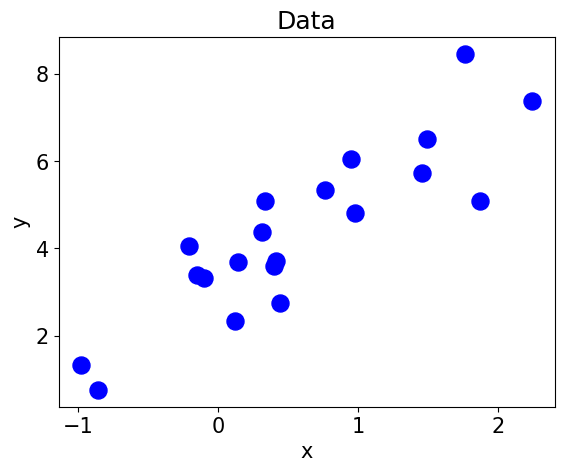

In [ ]:
plt.figure()
plt.scatter(data["x"],data["y"],color="blue",s=150,label="original data",zorder=-2)

plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Data")
plt.title("\n".join(title))
saver("originaldata")
plt.show()
plt.close()

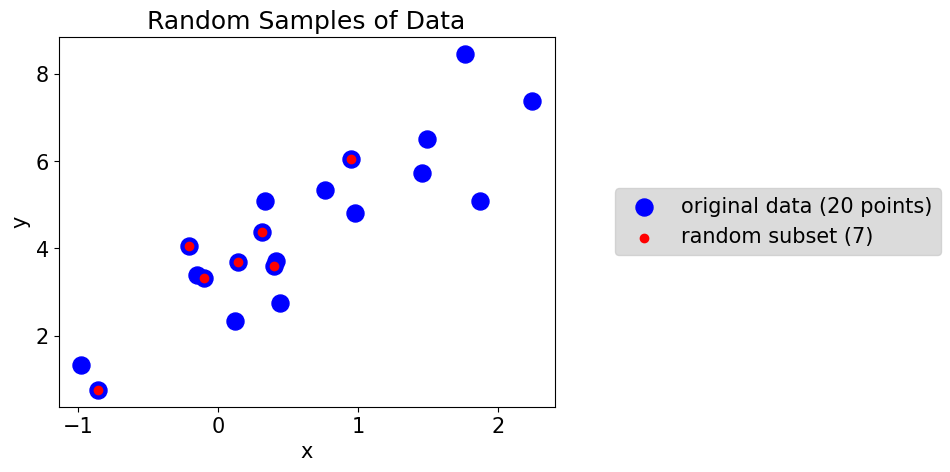

In [ ]:
plt.figure()
plt.scatter(data["x"],data["y"],color="blue",s=150,label="original data ({0:n} points)".format(N_points),zorder=-2)
plt.scatter(A["x"],A["y"],color="red",label="random subset ({0:n})".format(batchsize))

plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Random Samples of Data")
plt.title("\n".join(title))
legend("side")
saver("batch")
plt.show()
plt.close()

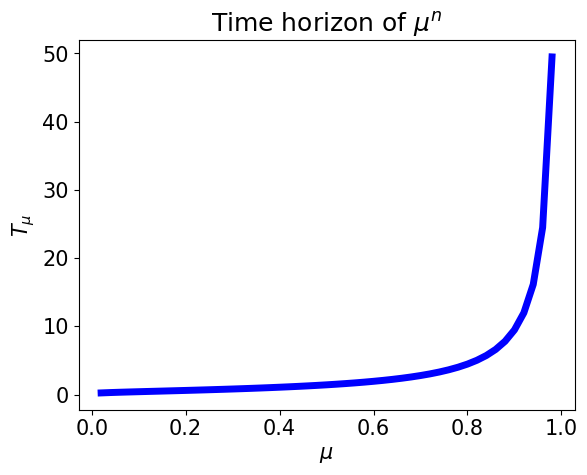

In [ ]:
murange=numpy.linspace(0,1,endpoint=False)
murange=murange[murange>0]

Timehorizon=1/numpy.log(1/murange)
plt.figure()
title=[]
title.append(r"Time horizon of $\mu^n$")
plt.title("\n".join(title))
plt.xlabel(r"$\mu$")
plt.ylabel(r"$T_{\mu}$")
plt.plot(murange,Timehorizon,color="blue")
saver("timehorizon")
plt.show()
plt.close()

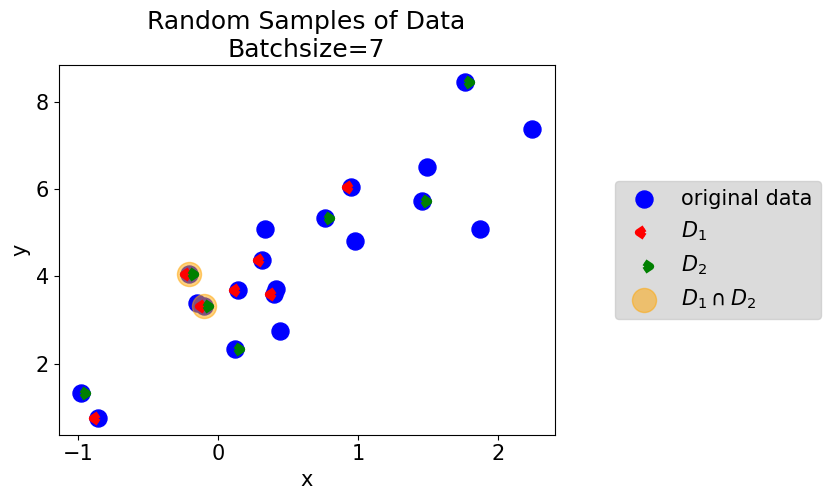

In [ ]:
plt.figure()
plt.scatter(data["x"],data["y"],color="blue",s=150,label="original data",zorder=-2)
plt.scatter(A["x"],A["y"],color="red",label=r"$D_1$",marker=8)
plt.scatter(B["x"],B["y"],color="green",label=r"$D_2$",marker=9)
plt.scatter(AB["x"],AB["y"],color="orange",s=300,label=r"$D_1\cap D_2$",zorder=-1,alpha=0.5)

plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("Random Samples of Data")
title.append("Batchsize={0:.0f}".format(batchsize))
plt.title("\n".join(title))
legend("side")
saver("batches")
plt.show()
plt.close()

In [ ]:
def datagenerator(N,seed=None,error=0.7,xmax=1.5):
    if seed is not None:
        numpy.random.seed(seed)
    df=pandas.DataFrame(numpy.random.normal(size=(N,2)),columns=["x","y"])
    df["label"]=df["y"]>error*numpy.random.normal(size=N)
    df=df.loc[(-xmax<df["x"])&(df["x"]<xmax),:]
    return df


In [ ]:
df=datagenerator(50,seed=SEED)
df.head()

,x,y,label
1,0.978738,2.240893,True
3,0.950088,-0.151357,False
4,-0.103219,0.410599,True
5,0.144044,1.454274,True
6,0.761038,0.121675,True


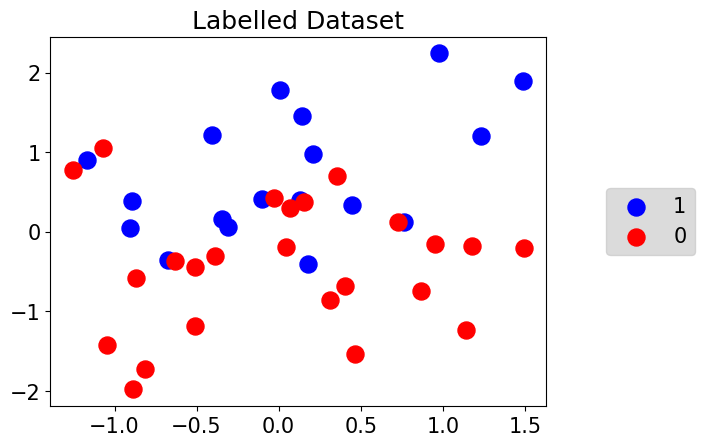

In [ ]:
plt.figure()
plt.scatter(df.loc[df["label"],"x"],df.loc[df["label"],"y"],color="blue",s=150,label="1")
plt.scatter(df.loc[~df["label"],"x"],df.loc[~df["label"],"y"],color="red",s=150,label="0")


legend("side")
(xleft,xright)=plt.xlim()
(ybottom,ytop)=plt.ylim()
title=[]
title.append("Labelled Dataset")
plt.title("\n".join(title))
saver("overtrainingexample")
plt.show()
plt.close()

In [ ]:
def makepoly(maxdegree,max_iter=None,seed=None):
    df_augmented=df.copy()

    featurenames=["y"]
    for d in range(1,maxdegree+1):
        s="x{0:n}".format(d)
        featurenames.append(s)
        df_augmented[s]=numpy.power(df["x"],d)


    df_augmented=df_augmented.drop(columns="x")

    args={"penalty":"none"}
    if seed is not None:
        args["random_state"]=SEED
    if max_iter is not None:
        args["max_iter"]=max_iter
    clf=sklearn.linear_model.LogisticRegression(**args).fit(df_augmented[featurenames],df_augmented["label"])

    coefs=pandas.Series(clf.coef_.squeeze(),index=featurenames)
    temp=pandas.concat([pandas.Series(clf.intercept_,index=["x0"]),coefs[1:]])/coefs["y"]
    temp=temp.reset_index(drop=True)


    def P(x):
        out=0
        for p in temp.index:
            out+=numpy.power(x,p)*temp[p]
        return out

    return P


myP=makepoly(6,max_iter=100,seed=SEED)

C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [ ]:
polys={}
for n_iter in range(5,51):
    polys[n_iter]=makepoly(6,max_iter=n_iter,seed=SEED)

C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\richa\ana

C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\richa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

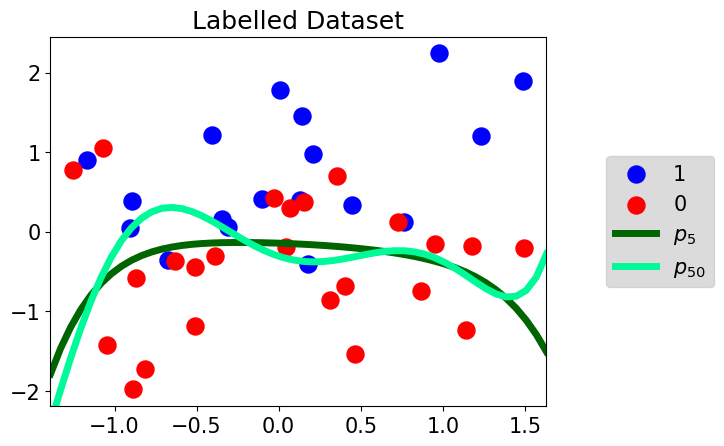

In [ ]:
xrange=numpy.linspace(xleft,xright)
plt.figure()
plt.scatter(df.loc[df["label"],"x"],df.loc[df["label"],"y"],color="blue",s=150,label="1")
plt.scatter(df.loc[~df["label"],"x"],df.loc[~df["label"],"y"],color="red",s=150,label="0")

p=numpy.min(list(polys.keys()))
myP=polys[p]
plt.plot(xrange,myP(xrange),color="darkgreen",label=r"$p_{{{0:n}}}$".format(p))

p=numpy.max(list(polys.keys()))
myP=polys[p]
plt.plot(xrange,myP(xrange),color="mediumspringgreen",label=r"$p_{{{0:n}}}$".format(p))

plt.xlim(xleft,xright)

legend("side")
plt.xlim(xleft,xright)
plt.ylim(ybottom,ytop)
title=[]
title.append("Labelled Dataset")
plt.title("\n".join(title))
saver("overtrainingexample")
plt.show()
plt.close()

In [ ]:
df_validation=datagenerator(10,seed=SEED+5)

In [ ]:
def error(poly,data):
    predicted_labels=data["y"]>poly(data["x"])
    return numpy.mean(predicted_labels!=data["label"])

In [ ]:
errorframe=pandas.DataFrame(numpy.nan,index=polys.keys(),columns=["training","validation"])

In [ ]:
for n,poly in polys.items():
    errorframe.loc[n,"validation"]=error(poly,df_validation)
    errorframe.loc[n,"training"]=error(poly,df)

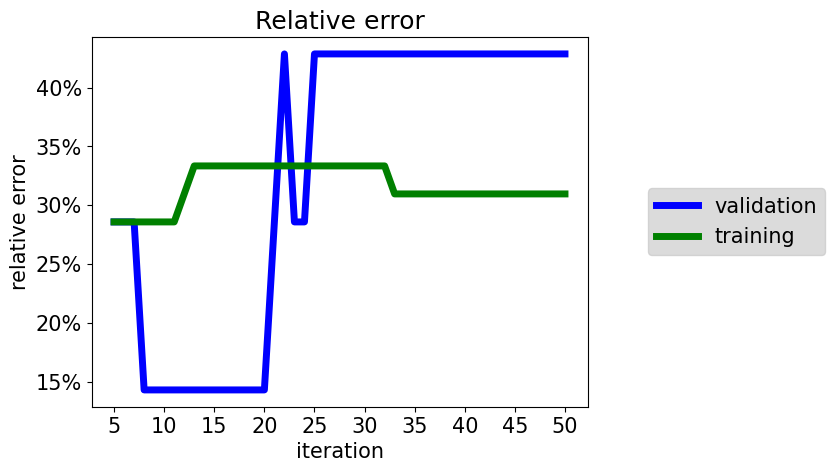

In [ ]:
plt.figure()
plt.plot(errorframe.index,errorframe["validation"],color="blue",label="validation")
plt.plot(errorframe.index,errorframe["training"],color="green",label="training")

plt.xlabel("iteration")
plt.ylabel("relative error")
#yticks = matplotlib.ticker.FormatStrFormatter('%.0f%%')
yticks = matplotlib.ticker.FormatStrFormatter('{x:.1f}%')

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0,decimals=0))
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
legend("side")
title=[]
title.append("Relative error")
plt.title("\n".join(title))
saver("trainingerrors")
plt.show()
plt.close()

In [ ]:
def f(x, y,xoffset=0,yoffset=0,xscale=1,yscale=1):
    r=((x-xoffset)/xscale) ** 2 + ((y-yoffset)/yscale) ** 2
    return -numpy.exp(-r)

x = numpy.linspace(-6, 6, 100)
y = numpy.linspace(-6, 6, 100)

X, Y = numpy.meshgrid(x, y)
Z = 2*f(X, Y,xscale=5,yscale=5)+f(X,Y,xoffset=2,xscale=0.25,yscale=0.25)

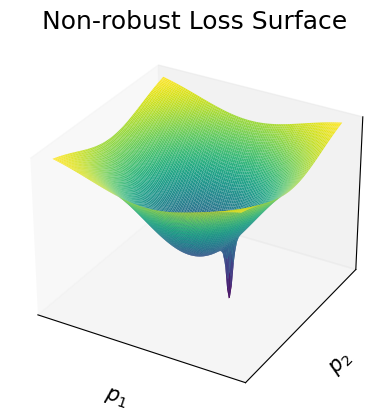

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel("$p_1$")
ax.set_ylabel("$p_2$")
title=[]
title.append("Non-robust Loss Surface")
plt.title("\n".join(title))
plt.xticks([],[])
plt.yticks([],[])
ax.set_zticks([],[])
ax.set_zlabel(r'Loss $\Lambda$')
saver("loss_surface")
plt.show()
plt.close()

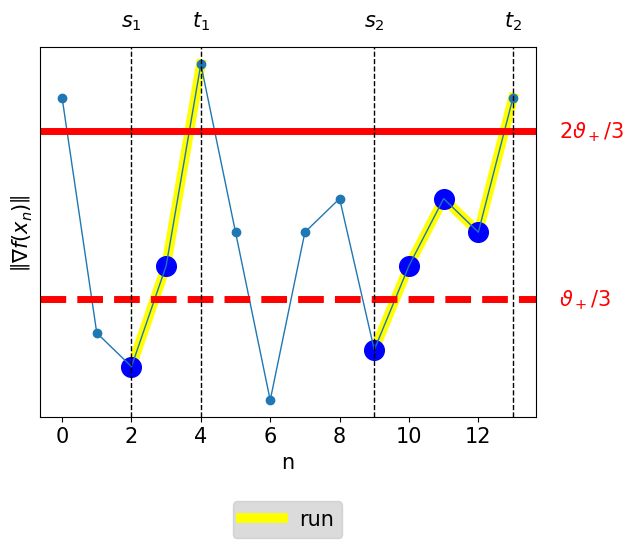

In [ ]:
#thresholds are 5 and 10
gradf=[11,4,3,6,12,7,2,7,8,3.5,6,8,7,11]
gradf=pandas.Series(gradf)/100
eps=0.1
annotations={
    r"$s_1$":2,
    r"$t_1$":4,
    r"$s_2$":9,
    r"$t_2$":13,
}

plt.figure()
plt.scatter(gradf.index,gradf)
plt.plot(gradf.index,gradf,linewidth=1)
plt.plot(range(2,5),gradf[2:5],color="yellow",linewidth=7,zorder=-5,label="run")
plt.plot(range(9,14),gradf[9:14],color="yellow",linewidth=7,zorder=-5)
plt.axhline(eps,color="red")
plt.axhline(eps/2,color="red",linestyle="dashed")
(_,right)=plt.xlim()
plt.text(1.05*right,eps,r"$2\vartheta_+/3$",va="center",color="red")
plt.text(1.05*right,eps/2,r"$\vartheta_+/3$",va="center",color="red")



(_,top)=plt.ylim()
for (label,x) in annotations.items():
    plt.axvline(x,linewidth=1,linestyle="dashed",color="black")
    plt.text(x,1.05*top,label,ha="center")

run=gradf.loc[(annotations[r"$s_1$"]<=gradf.index)&(gradf.index<annotations[r"$t_1$"])]
plt.scatter(run.index,run,s=200,color="blue")

run=gradf.loc[(annotations[r"$s_2$"]<=gradf.index)&(gradf.index<annotations[r"$t_2$"])]
plt.scatter(run.index,run,s=200,color="blue")


plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("n")
plt.yticks([],[])
plt.ylabel(r"$\left\|\nabla f(x_n)\right\|$")
legend("bottom")
saver("run")
plt.show()
plt.close()


In [ ]:
xmax=2
xknots=numpy.sort(scipy.stats.uniform.rvs(size=30,loc=-xmax,scale=2*xmax,random_state=SEED))
yknots=xknots**2+scipy.stats.norm.rvs(size=len(xknots),scale=0.1,random_state=SEED)
cs=scipy.interpolate.CubicSpline(xknots,yknots)

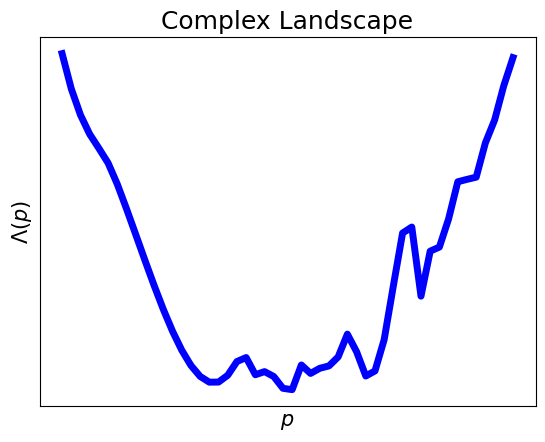

In [ ]:
xrange=numpy.linspace(min(xknots),max(xknots))
plt.figure()
plt.plot(xrange,cs(xrange),color="blue")
title=["Complex Landscape"]
plt.title("\n".join(title))
plt.xticks([])
plt.yticks([])
ax = plt.gca()
plt.xlabel("$p$")
plt.ylabel(r"$\Lambda(p)$")
saver("cobblestonelandscape")
plt.show()
plt.close()